# Measurement Error Mitigation

In [3]:
from qiskit import QuantumCircuit, QuantumRegister, transpile, assemble
from qiskit.visualization import array_to_latex
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter

C:\Users\Pawel\AppData\Local\Temp\ipykernel_23292\1246129984.py:5: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter


In [4]:
def get_noise(p):
    error_meas = pauli_error([('X',p), ('I', 1 - p)])
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, "measure") # measurement error is applied to measurements
    return noise_model

In [28]:
def measure(backend, noise_model = None):
    qr = QuantumRegister(2)
    meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal') #returns array of 4 simple gates with X at 00, 01, 10, 11

    t_qc = transpile(meas_calibs, backend)
    qobj = assemble(t_qc, shots=10000)
    cal_results = backend.run(qobj, noise_model=noise_model, shots=10000).result()

    meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
    return meas_fitter.filter

In [6]:
def run_simple_hadamard_circ(backend, noise_model = None):
    qc = QuantumCircuit(2,2)
    qc.h(0)
    qc.cx(0,1)
    qc.measure([0, 1], [0, 1])

    t_qc = transpile(qc, backend)
    qobj = assemble(t_qc, shots=10000)
    results = backend.run(qobj, noise_model=noise_model, shots=10000).result()
    return results

In [23]:
import sys
sys.path.append('..')
import utils.backends as backends

# backend, noise_model = backends.aer_simulator(), None
# backend, noise_model = backends.aer_simulator(), backends.get_noise(0.1)
# backend, noise_model = backends.qasm_simulator(), backends.get_noise(0.1)
backend, noise_model = backends.aer_simulator(), backends.get_real_noise()
# backend, noise_model = backends.real_machine(), None

In [24]:
results = run_simple_hadamard_circ(backend, noise_model)
results.get_counts()

{'10': 892, '00': 4101, '11': 4086, '01': 921}

In [25]:
# Get the filter object
meas_fitter = measure(backend, noise_model)
array_to_latex(meas_fitter.cal_matrix)

<IPython.core.display.Latex object>

In [26]:
# Results with mitigation
mitigated_results = meas_fitter.apply(results)
mitigated_counts = mitigated_results.get_counts()

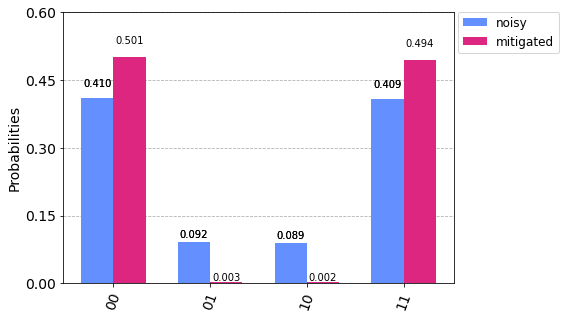

In [27]:
from qiskit.visualization import plot_histogram 
noisy_counts = results.get_counts()
plot_histogram([noisy_counts, mitigated_counts], legend=['noisy', 'mitigated'])